In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import warnings
warnings.filterwarnings(action='ignore')
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size =64
train_dataset = datasets.FashionMNIST(root='./FashionMNIST/',
                               train=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root='./FashionMNIST/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


In [3]:
print(train_loader.dataset.train_data.shape)
print(train_loader.dataset.train_labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [4]:
# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
classes = ('T-shirt/top', 'Trouser','Pullover','Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle-boot')

torch.Size([64, 1, 28, 28])
torch.Size([64])


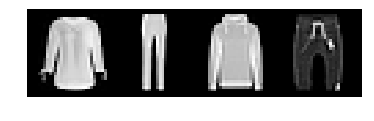

T-shirt/top Trouser Pullover Trouser


In [5]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[:4],nrow=4))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
class Inception(torch.nn.Module):
    def __init__(self,in_channels):
        super(Inception,self).__init__()
        
        self.branch1x1 = nn.Conv2d(in_channels,16,kernel_size=1)
        
        self.branch5x5_1 = nn.Conv2d(in_channels,16,kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16,24,kernel_size=5,padding=2)
        
        self.branch3x3_1 = nn.Conv2d(in_channels,16,kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16,24,kernel_size=3,padding=1)
        self.branch3x3_3 = nn.Conv2d(24,24,kernel_size=3,padding=1)
        
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
        
    def forward(self,x):
        
        branch1x1 = self.branch1x1(x)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)
        
        branch_pool = F.avg_pool2d(x,kernel_size=3,padding=1,stride =1)
        branch_pool = self.branch_pool(branch_pool)
        
        
        output =[ branch1x1,branch5x5,branch3x3,branch_pool]
        
        return torch.cat(output,1)

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(88,20,kernel_size=5)
        
        self.incept1 = Inception(in_channels=10)
        self.incept2 = Inception(in_channels=20)
        
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(1408, 10)
        
    def forward(self,x):
        in_size = x.size(0)
        
        
        x = F.relu(self.mp(self.conv1(x)))
        x = self.incept1(x)
        
        x = F.relu(self.mp(self.conv2(x)))
        x = self.incept2(x)
        
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.fc(x)
        return F.log_softmax(x)

In [17]:
model = Net()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [18]:
for epoch in range(10):
    for i ,(data,target) in enumerate(train_loader):
        data,target = Variable(data),Variable(target)
        optimizer.zero_grad()
        y_pred = model.forward(data)
        loss = criterion(y_pred,target)
        
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301847
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.286026
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.218995
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.697130
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.814392
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.704826
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.716702
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.630160
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.717141
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.564631
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.834481
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.669474
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.614401
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.594722
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.591836
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.491253
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.534951
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.772181
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.633500
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.396705
Train Epoch:

In [19]:
test_loss = 0
correct = 0
for data, target in test_loader:
    data, target = Variable(data), Variable(target)
    output = model.forward(data)
    # sum up batch loss
    test_loss += criterion(output, target).item()
    # get the index of the max
    pred = output.data.max(dim=1,keepdim=True)[1]
    
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0057, Accuracy: 8711/10000 (87%)

